In [62]:
# TP 6 - Zéro coupons et modèle de Ho-Lee

import numpy as np
import matplotlib.pyplot as plt

# paramètres généraux
Nmax = 10 # nombre d'étapes
Tmax = Nmax # temps final
deltat = Tmax/Nmax # pas de temps
pi = 0.4 # proba modèle Ho-Lee
delta = 1.2 # mesure de volatilité Ho-Lee
r = 0.04 # rendement

In [63]:
# évaluation des valeurs initiales des 0-coupons:
# chaque année, le prix est multiplié par (1+r)
# donc au bout de k étapes (k*deltat années), le prix est
# multiplié par (1+r)^(k*deltat), et il vaudra 1 euro
def Z0(k):
    z0 = (1+r)**(-k*deltat)
    return z0
Z0(10)

0.6755641688257986

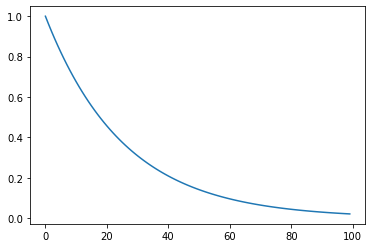

In [64]:
# dessin des valeurs initiales des 0-coupons
plt.plot(range(100),Z0(np.arange(100)))

In [66]:
# fonction eta du modèle Ho-Lee
def eta(l,x): # x = 0 (down) ou 1 (up); l = nb d'étapes entre t et T => l = theta/deltat
    if x==0:
        e = 1/(pi+(1-pi)*delta**l)
    else:
        e = delta**l/(pi+(1-pi)*delta**l)
    return e

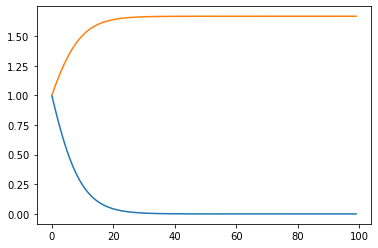

In [67]:
# dessin des valeurs de eta
plt.plot(range(100),eta(np.arange(100),0))
plt.plot(range(100),eta(np.arange(100),1))

In [68]:
1/(1.02)**1

0.9803921568627451

In [69]:
# calcul des 0-coupons Z(n,j,k) par récurrence:
# t = n*deltat (temps courant), T = k*deltat (temps final), j = #up
Z = -np.ones((Nmax+1,Nmax+1,Nmax+1))
# initialisation à t=0 (donc n=0)
Z[0,0,:] = Z0(np.arange(Nmax+1))
# boucle sur t
for n in range(1,Nmax+1):
    for k in range(n,Nmax+1):
        # j = 0 (on n'a jamais fait de up => on vient de faire un down)
        Z[n,0,k] = Z[n-1,0,k]/Z[n-1,0,n]*eta(k-n,0)
        # boucle sur j=1..n (on peut supposer qu'on vient de faire up)
        for j in range(1,n+1):
            Z[n,j,k] = Z[n-1,j-1,k]/Z[n-1,j-1,n]*eta(k-n,1)

In [75]:
Z


array([[[ 1.        ,  0.96153846,  0.92455621, ...,  0.73069021,
          0.70258674,  0.67556417],
        [-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ],
        [-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ],
        ...,
        [-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ],
        [-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ],
        [-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ]],

       [[-1.        ,  1.        ,  0.85851648, ...,  0.29801768,
          0.24520709,  0.20097632],
        [-1.        ,  1.        ,  1.03021978, ...,  1.06785123,
          1.05434561,  1.03699368],
        [-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ],
        ...,
        [-1.        , -1.        , -1.        , ..., -

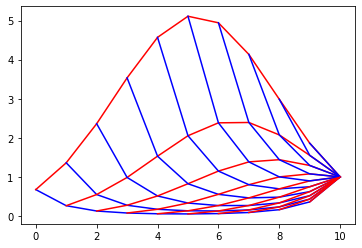

In [49]:
# dessin des 0-coupons
for i in range(Nmax+1):
    # courbes down
    plt.plot(range(i,Nmax+1),Z[i:Nmax+1,i,Nmax],'b')
    # courbes up
    plt.plot(range(i,Nmax+1),Z[[j for j in range(i,Nmax+1)],[j for j in range(Nmax+1-i)],Nmax],'r')

In [50]:
# taux correspondants
Y = -np.ones((Nmax+1,Nmax+1,Nmax+1))
for n in range(Nmax+1):
    for j in range(n+1):
        for k in range(n+1,Nmax+1):
            Y[n,j,k] = -np.log(Z[n,j,k])/((k-n)*deltat)

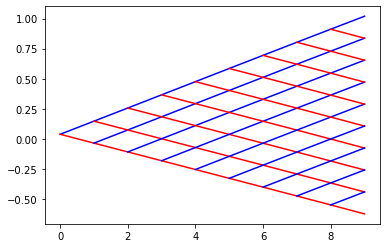

In [51]:
# dessin des taux
for i in range(Nmax+1):
    # courbes down
    plt.plot(range(i,Nmax),Y[i:Nmax,i,Nmax],'b')
    # courbes up
    plt.plot(range(i,Nmax),Y[[j for j in range(i,Nmax)],[j for j in range(Nmax-i)],Nmax],'r')

In [12]:
Y[:,0,Nmax]

array([ 0.01980263,  0.03014452,  0.04048651,  0.05082857,  0.06117063,
        0.07151267,  0.08185463,  0.09219648,  0.10253817,  0.11287966,
       -1.        ])

In [13]:
# taux actuariels
A = -np.ones((Nmax+1,Nmax+1,Nmax+1))
for n in range(Nmax+1):
    for j in range(n+1):
        for k in range(n+1,Nmax+1):
            A[n,j,k] = np.exp(-np.log(Z[n,j,k])/((k-n)*deltat))-1

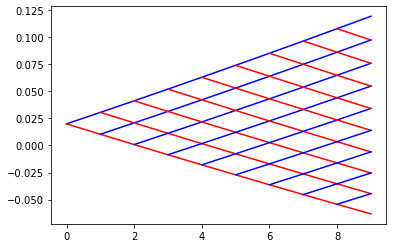

In [14]:
# dessin des taux actuariels
for i in range(Nmax+1):
    # courbes down
    plt.plot(range(i,Nmax),A[i:Nmax,i,Nmax],'b')
    # courbes up
    plt.plot(range(i,Nmax),A[[j for j in range(i,Nmax)],[j for j in range(Nmax-i)],Nmax],'r')

In [15]:
# caplets (option d'achat qui couvre contre une envolée des taux)
K = 0.035 # strike: taux plafond à 3.5%

In [16]:
# option d'achat
C = -np.ones((Nmax+1,Nmax+1,Nmax+1))
for k in range(1,Nmax+1):
    n=k # on est à l'échéance: t=T
    for j in range(n+1):
        # à T-dt, le zéro coupon vaut Z(k-1,j,k)
        # or Z(k-1,j,k)*(1+r_T) = Z(k,j,k) = 1
        # donc 1+r_T = 1/Z(k-1,j,k)
        C[n,j,k] = max(((1/Z[k-1,j,k])-1)-K,0) # payoff
    n=k-1 # on est juste avant l'échéance: t=T-dt
    for j in range(n+1):
        # C(n,j,k) = E(C(n+1,j,k))/(1+r_T)
        # or 1/(1+r_T) = Z(k-1,j,k)
        C[n,j,k] = C[n+1,j,k]*Z[k-1,j,k]
    for n in range(k-2,-1,-1): # récurrence rétrograde
        for j in range(n+1):
            # C(n,j,k) = E(C(n+1,j,k))/(1+r_(t+dt))
            # or 1/(1+r_(t+dt)) = Z(n,j,n+1) car Z(n+1,j,n+1)=1
            C[n,j,k] = (pi*C[n+1,j,k]+(1-pi)*C[n+1,j+1,k])*Z[n,j,n+1]


In [17]:
print('Equivalent en taux de la couverture finale, en %:')
print(C[0,0,Nmax]*100)

Equivalent en taux de la couverture finale, en %:
0.4827819634842077


In [18]:
print('Couverture caplet à échéance finale pour 100k€:')
print(C[0,0,Nmax]*100000)

Couverture caplet à échéance finale pour 100k€:
482.7819634842077


In [19]:
print('Equivalent en taux de la couverture cap à toutes échéances, en %:')
print(sum(C[0,0,1:Nmax+1])*100)

Equivalent en taux de la couverture cap à toutes échéances, en %:
2.6482343169615583


In [20]:
print('Couverture cap à toutes échéances (10 ans) pour 100k€:')
print(sum(C[0,0,1:Nmax+1])*100000)

Couverture cap à toutes échéances (10 ans) pour 100k€:
2648.2343169615583
